In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import os
import matplotlib.colors as mcolors
import pickle
from PIL import Image

from ipynb.fs.full.functions_for_creating_plots import *
os.chdir(os.getcwd())

In [2]:
## Dictionary holding the numbers of the molecules in the model (for explanation, look up model-figure.pdf)
molecules_dict={'$\mathbf{G_{GTP}}$':[23,33],
                '$\mathbf{IP_{3}}$':[40],
                'Total Arrestin-Receptor':[10,11,12,13,14,15],
                'PM Arrestin-Receptor':[10,11,12],
                'IC Arrestin-Receptor':[13,14,15]}

## Determine ligand concentrations              
ligand_ccs=(10 ** np.arange(-6, 1.1, 1))
internalisation_status=['With_internalisation','No_internalisation']

## Simulation time
simulation_time=1200


subplot_layout=[['.','B','C','D'],
                ['E_up','F_up','G_up','H_up'],
                ['E_low','F_low','G_low','H_low'],
                ['I','J','K','K']]#,
                #['L','L','L','L'],
                #['M','M','M','M']]


subplot_label_list=[['','B','C','D'],
                ['E','F','G','H'],
                ['','','',''],
                ['I','J','K',''],
                ['L','','M','']]


### Add plots for the first row (subplots **B - D**)
#### To be able to add additional subplots to the subplots_mosaic object later, plt.show() mustn't run plt.show() function and close the figure.
#### -> To prevent this plt.ioff() is run, but somehow it only takes effect after running this cell at least 2 times
## !!!! If running this script from scratch, run this cell 2 times, so subplots_mosaic object can be updated later with additional subplots!!!!!


In [3]:
def draw_kinetic_concentration_curve_of_molecule_with_different_ligand_ccs(molecule,molecules_dict,kon,koff,intern_status,process_name,ligand_ccs,\
                                                                           color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                           subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                           subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                           legend_title,subplot_legend_title_fontsize_nominator,subplot_label,\
                                                                           subplot_label_fontsize_nominator):
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',intern_status,process_name,'')

    ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
    ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

    ## Define which subplot we eant to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    # Extract the maximum value of receptor-arrestin concentrations, in order to determine the common Y-axis range for the plots E-H
    arrestin_receptor_max_response=0
    
    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file with only columns that contain data 
    #  for the molecule to be plotted
    for ligand,color in zip(ligands,colors):
        fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
        col_nums=[int(x+1) for x in molecules_dict[molecule]]
        col_nums.append(0)
        mol_ccs_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
        plot=axis.plot(mol_ccs_df.index.tolist(),np.sum(mol_ccs_df.loc[:,:],1),label=ligand,color=color)
        ## Extract the maximum value of Arrestin-Receptor curves 
        if molecule=='Total Arrestin-Receptor' and max(np.sum(mol_ccs_df.loc[:,:],1))>arrestin_receptor_max_response:
            arrestin_receptor_max_response=max(np.sum(mol_ccs_df.loc[:,:],1))

    
    ## Customize legend, plot title, axis labels 
    plot_area=fig_width*fig_height

    axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title="$\mathbf{Low\ K_{off}}$"
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('Time (s)',fontweight="bold",fontsize=axis_label_fontsize)
    axis.set_ylabel(molecule,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)

    axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)
    return plot,arrestin_receptor_max_response

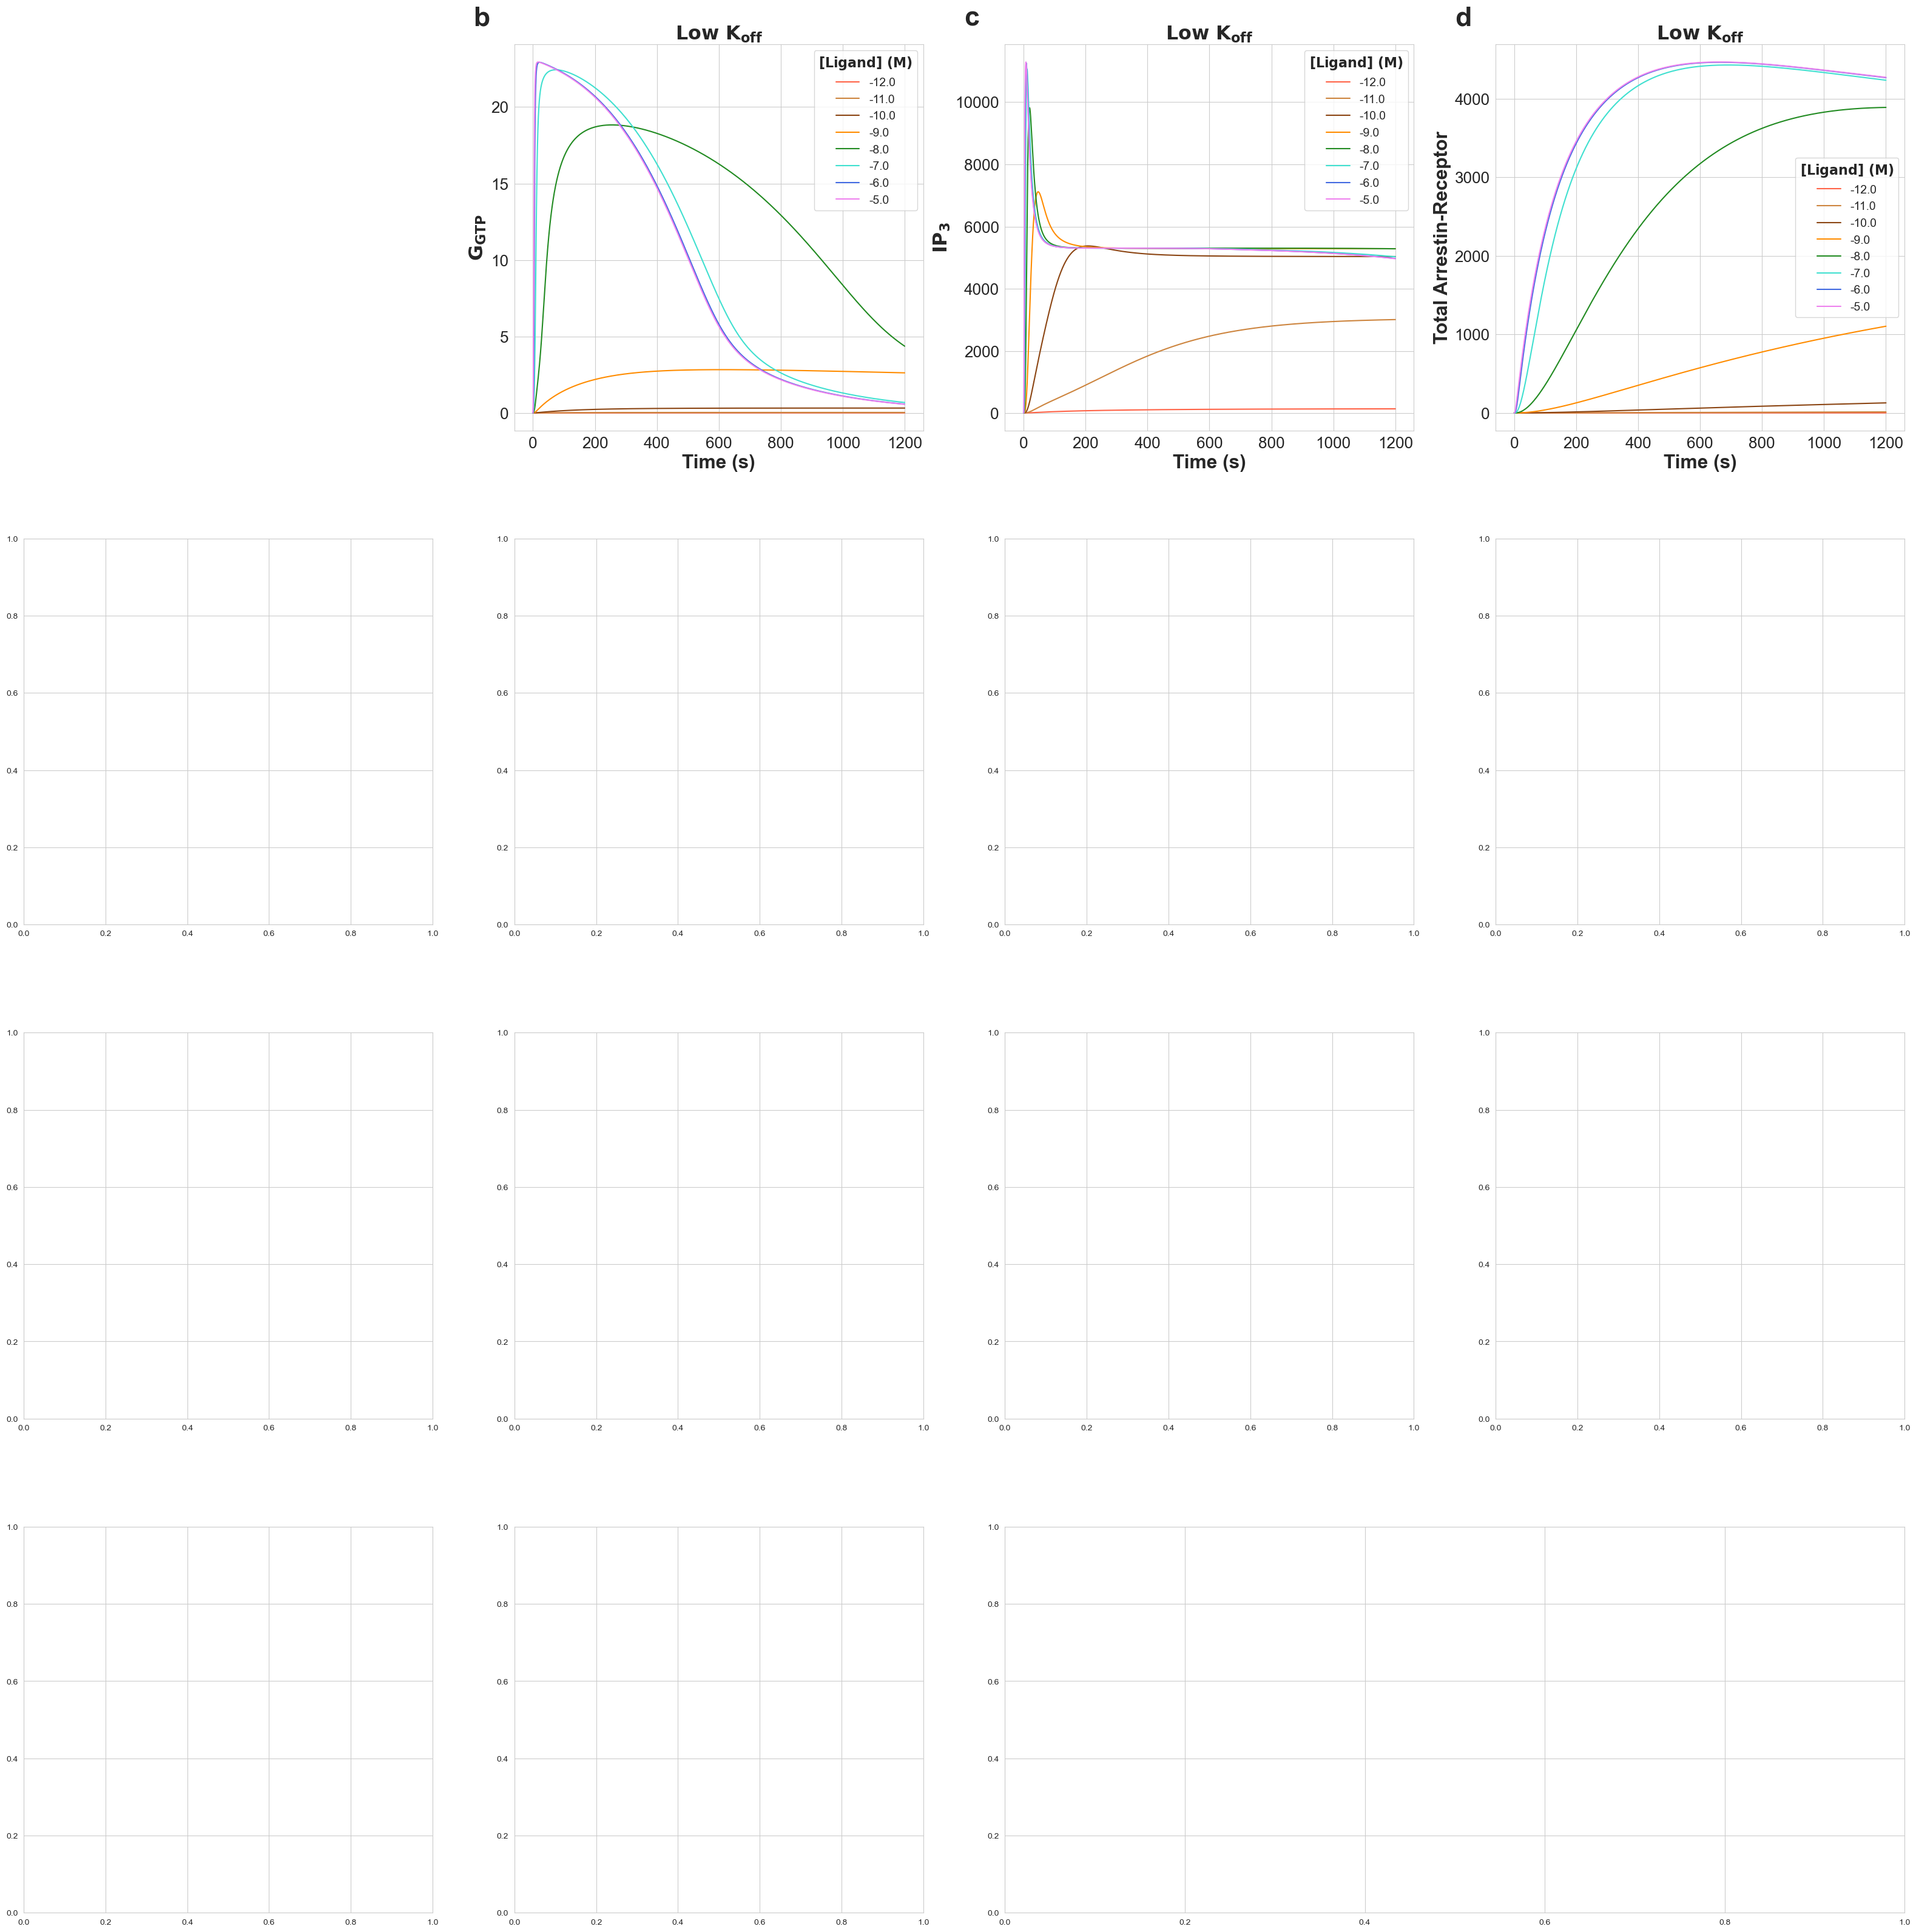

In [4]:
## Define subplots and molecules to plot
subplots_names=['B','C','D']
subplot_labels=['B','C','D']
molecules_to_plot=['$\mathbf{G_{GTP}}$','$\mathbf{IP_{3}}$','Total Arrestin-Receptor']

## Define the parameters for the plots
kon=0.3
koff=0.0003
ligand_ccs=(10 ** np.arange(-6, 1.1, 1))
intern_status='With_internalisation'
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']



fig_width=40
fig_height=40

fig,ax=plt.subplot_mosaic(subplot_layout,figsize=(fig_width,fig_height),gridspec_kw={'hspace':0.28})


## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=115
legend_title='$\mathbf{[Ligand]\ (M)}$'
subplot_legend_title_fontsize_nominator=100



for subplot_name,molecule,subplot_label in zip(subplots_names,molecules_to_plot,subplot_labels):
    ax[subplot_name],arrestin_receptor_max_response=draw_kinetic_concentration_curve_of_molecule_with_different_ligand_ccs(molecule,molecules_dict,kon,koff,intern_status,process_name,ligand_ccs,\
                                                                           color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                           subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                           subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                           legend_title,subplot_legend_title_fontsize_nominator,subplot_label,\
                                                                           subplot_label_fontsize_nominator)
    if molecule=='Total Arrestin-Receptor':
        with open('../data/temp_data_for_plotting/arrestin_receptor_max_response.pkl','wb') as file:
            pickle.dump(arrestin_receptor_max_response,file)


        
## Save fig and axes object for later to add more subplots to it
with open('../data/temp_data_for_plotting/temporary_plot_B_D_fig_object.pkl','wb') as file:
    pickle.dump(fig,file)
with open('../data/temp_data_for_plotting/temporary_plot_B_D_axes_object.pkl','wb') as file:
    pickle.dump(ax,file)



### Add plots for the second and third row (**E - G**)

In [5]:
def draw_kinetic_concentration_curve_of_molecule_with_different_koff_values(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                                                           color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                           subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                           subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                           legend_title,subplot_legend_title_fontsize_nominator,legend_handles,ylim,subplot_label,\
                                                                           subplot_label_fontsize_nominator):
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',intern_status,process_name,'')

    ## Define which subplot we eant to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
    for koff,color,label in zip(koff_list,colors,legend_handles):
        ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
        ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

        label=label + str(koff)
        for ligand in ligands:
            fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
            col_nums=[int(x+1) for x in molecules_dict[molecule]]
            col_nums.append(0)
            mol_ccs_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
            plot=axis.plot(mol_ccs_df.index.tolist(),np.sum(mol_ccs_df.loc[:,:],1),label=label,color=color)
    
    ## Customize legend, plot title, axis labels 
    plot_area=fig_width*fig_height

    axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title_text=intern_status.replace('_','\ ')
    title=r"$\mathbf{{title}}$".replace('title',title_text)
 
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('Time (s)',fontweight="bold",fontsize=axis_label_fontsize)
    axis.set_ylabel(molecule,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    axis.set_ylim(0,ylim)

    ## If plot is in the upper row (=with internalistaion), then add plot label 
    if intern_status=='With_internalisation':
        axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)
        
    return(plot)

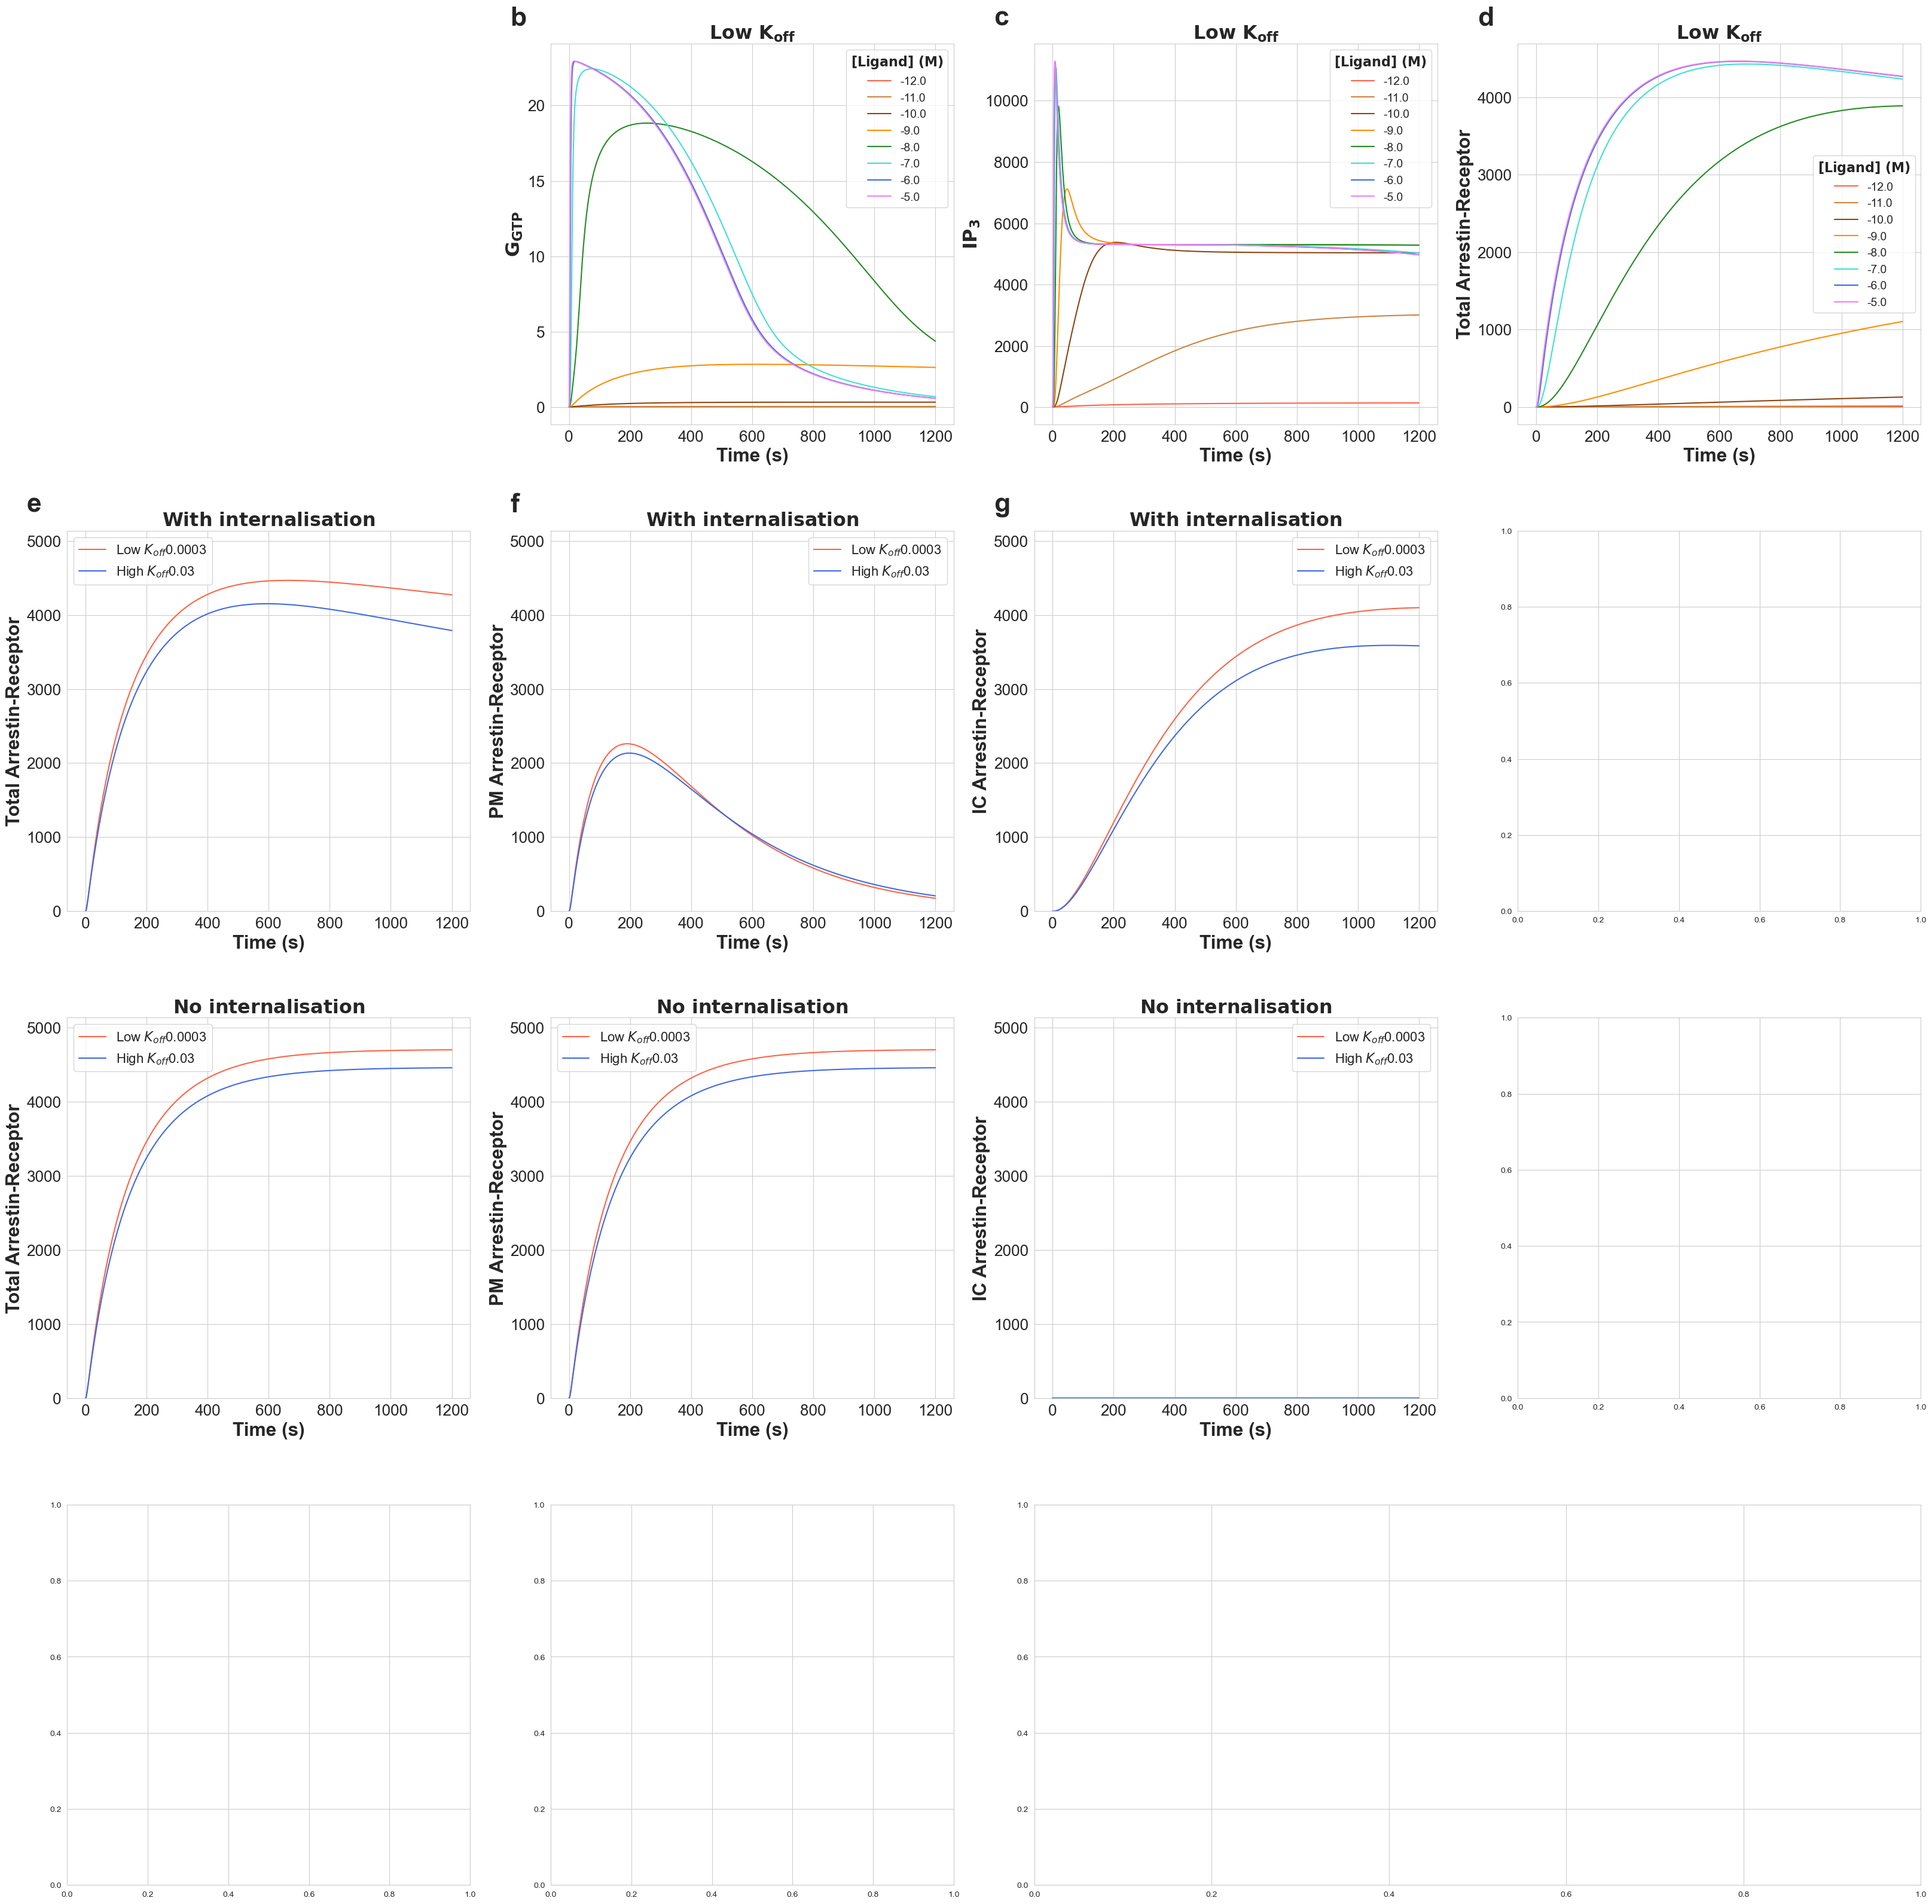

In [6]:
subplots_names=[['E_up','F_up','G_up'],
                ['E_low','F_low','G_low']]
subplot_labels=['E','F','G']
molecules_to_plot=['Total Arrestin-Receptor','PM Arrestin-Receptor','IC Arrestin-Receptor']

kon=0.3
koff_list=[0.0003,0.03]
internalisation_status=['With_internalisation','No_internalisation']
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','royalblue']#'peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']

ligand_ccs=(10 ** np.arange(1, 1.1, 1))

fig_width=40
fig_height=40

#fig,ax=plt.subplot_mosaic(subplot_layout,figsize=(fig_width,fig_height))

## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=100
subplot_legend_title_fontsize_nominator=100
#legend_title='$\mathbf{K_{off}}$'
legend_title=None
legend_handles=['Low $K_{off}$','High $K_{off}$']

### Load the previosly ceated figur and axes object to plot to
with open('../data/temp_data_for_plotting/temporary_plot_B_D_fig_object.pkl','rb') as file:
    fig=pickle.load(file)
    plt.close()
with open('../data/temp_data_for_plotting/temporary_plot_B_D_axes_object.pkl','rb') as file:
    ax=pickle.load(file)
with open('../data/temp_data_for_plotting/arrestin_receptor_max_response.pkl','rb') as file:
    arrestin_receptor_max_response=pickle.load(file)

## Set common y-axis limit for all the plots in E-H
ylim=arrestin_receptor_max_response*1.15

for molecule,colnum,subplot_label in zip(molecules_to_plot,range(np.asarray(subplots_names).shape[1]),subplot_labels):
    for intern_status,rownum in zip(internalisation_status,range(np.asarray(subplots_names).shape[0])):
        subplot_name=subplots_names[rownum][colnum]
        ax[subplot_name]=draw_kinetic_concentration_curve_of_molecule_with_different_koff_values(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                                                           color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                           subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                           subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                           legend_title,subplot_legend_title_fontsize_nominator,legend_handles,ylim,subplot_label,\
                                                                           subplot_label_fontsize_nominator)

## Save fig and axes object for later to add more subplots to it
with open('../data/temp_data_for_plotting/temporary_plot_B_G_fig_object.pkl','wb') as file:
    pickle.dump(fig,file)
with open('../data/temp_data_for_plotting/temporary_plot_B_G_axes_object.pkl','wb') as file:
    pickle.dump(ax,file)

### Add 2 DR-curve plots (__H__)

In [7]:
def draw_DR_points_plus_fit_DR_curve(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                    color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                    subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                    subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                    legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                                    subplot_label,subplot_label_fontsize_nominator,plot_dot_size):
    
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',intern_status,process_name,'')

    ## Define which subplot we want to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    
    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
    for koff,color,label in zip(koff_list,colors,legend_handles):
        ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
        ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

        ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
        DR_points=[]
        label=label + str(koff)

        for ligand in ligands:
            fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
            col_nums=[int(x+1) for x in molecules_dict[molecule]]
            col_nums.append(0)
            mol_ccs_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
            response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
            DR_points.append(response_at_time)
        
        ## Function to fit DR curve on the DR-points extracted from the simulated data and return logEC50 for plotting the fitted DR curve
        def func(ligands, logec50):
            return max(DR_points) / (1 + 10 ** (logec50 - np.log10(ligands)))
        logec50, pcov = curve_fit(func, 10**ligands, DR_points,bounds=(-19,-1))

        ## Create x-axis values for DR curve
        ligandrange = np.linspace(ligands[0], ligands[-1], 100)
        axis.plot((ligandrange), func(10 ** ligandrange, logec50), color=color)
        axis.scatter(ligands, DR_points,label=label, color=color,s=plot_dot_size)
        
        
    #plot=axis.plot(mol_ccs_df.index.tolist(),np.sum(mol_ccs_df.loc[:,:],1),label=label,color=color)
    
    ## Customize legend, plot title, axis labels 
    plot_area=fig_width*fig_height

    axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title_text=intern_status.replace('_','\ ')
    title=r"$\mathbf{{title}}$".replace('title',title_text)
 
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('Time (s)',fontweight="bold",fontsize=axis_label_fontsize)
    axis.set_ylabel(molecule,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    axis.set_ylim(0,ylim)

    ## If plot is in the upper row (=with internalistaion), then add plot label 
    if intern_status=='With_internalisation':
        axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)

    return(axis)

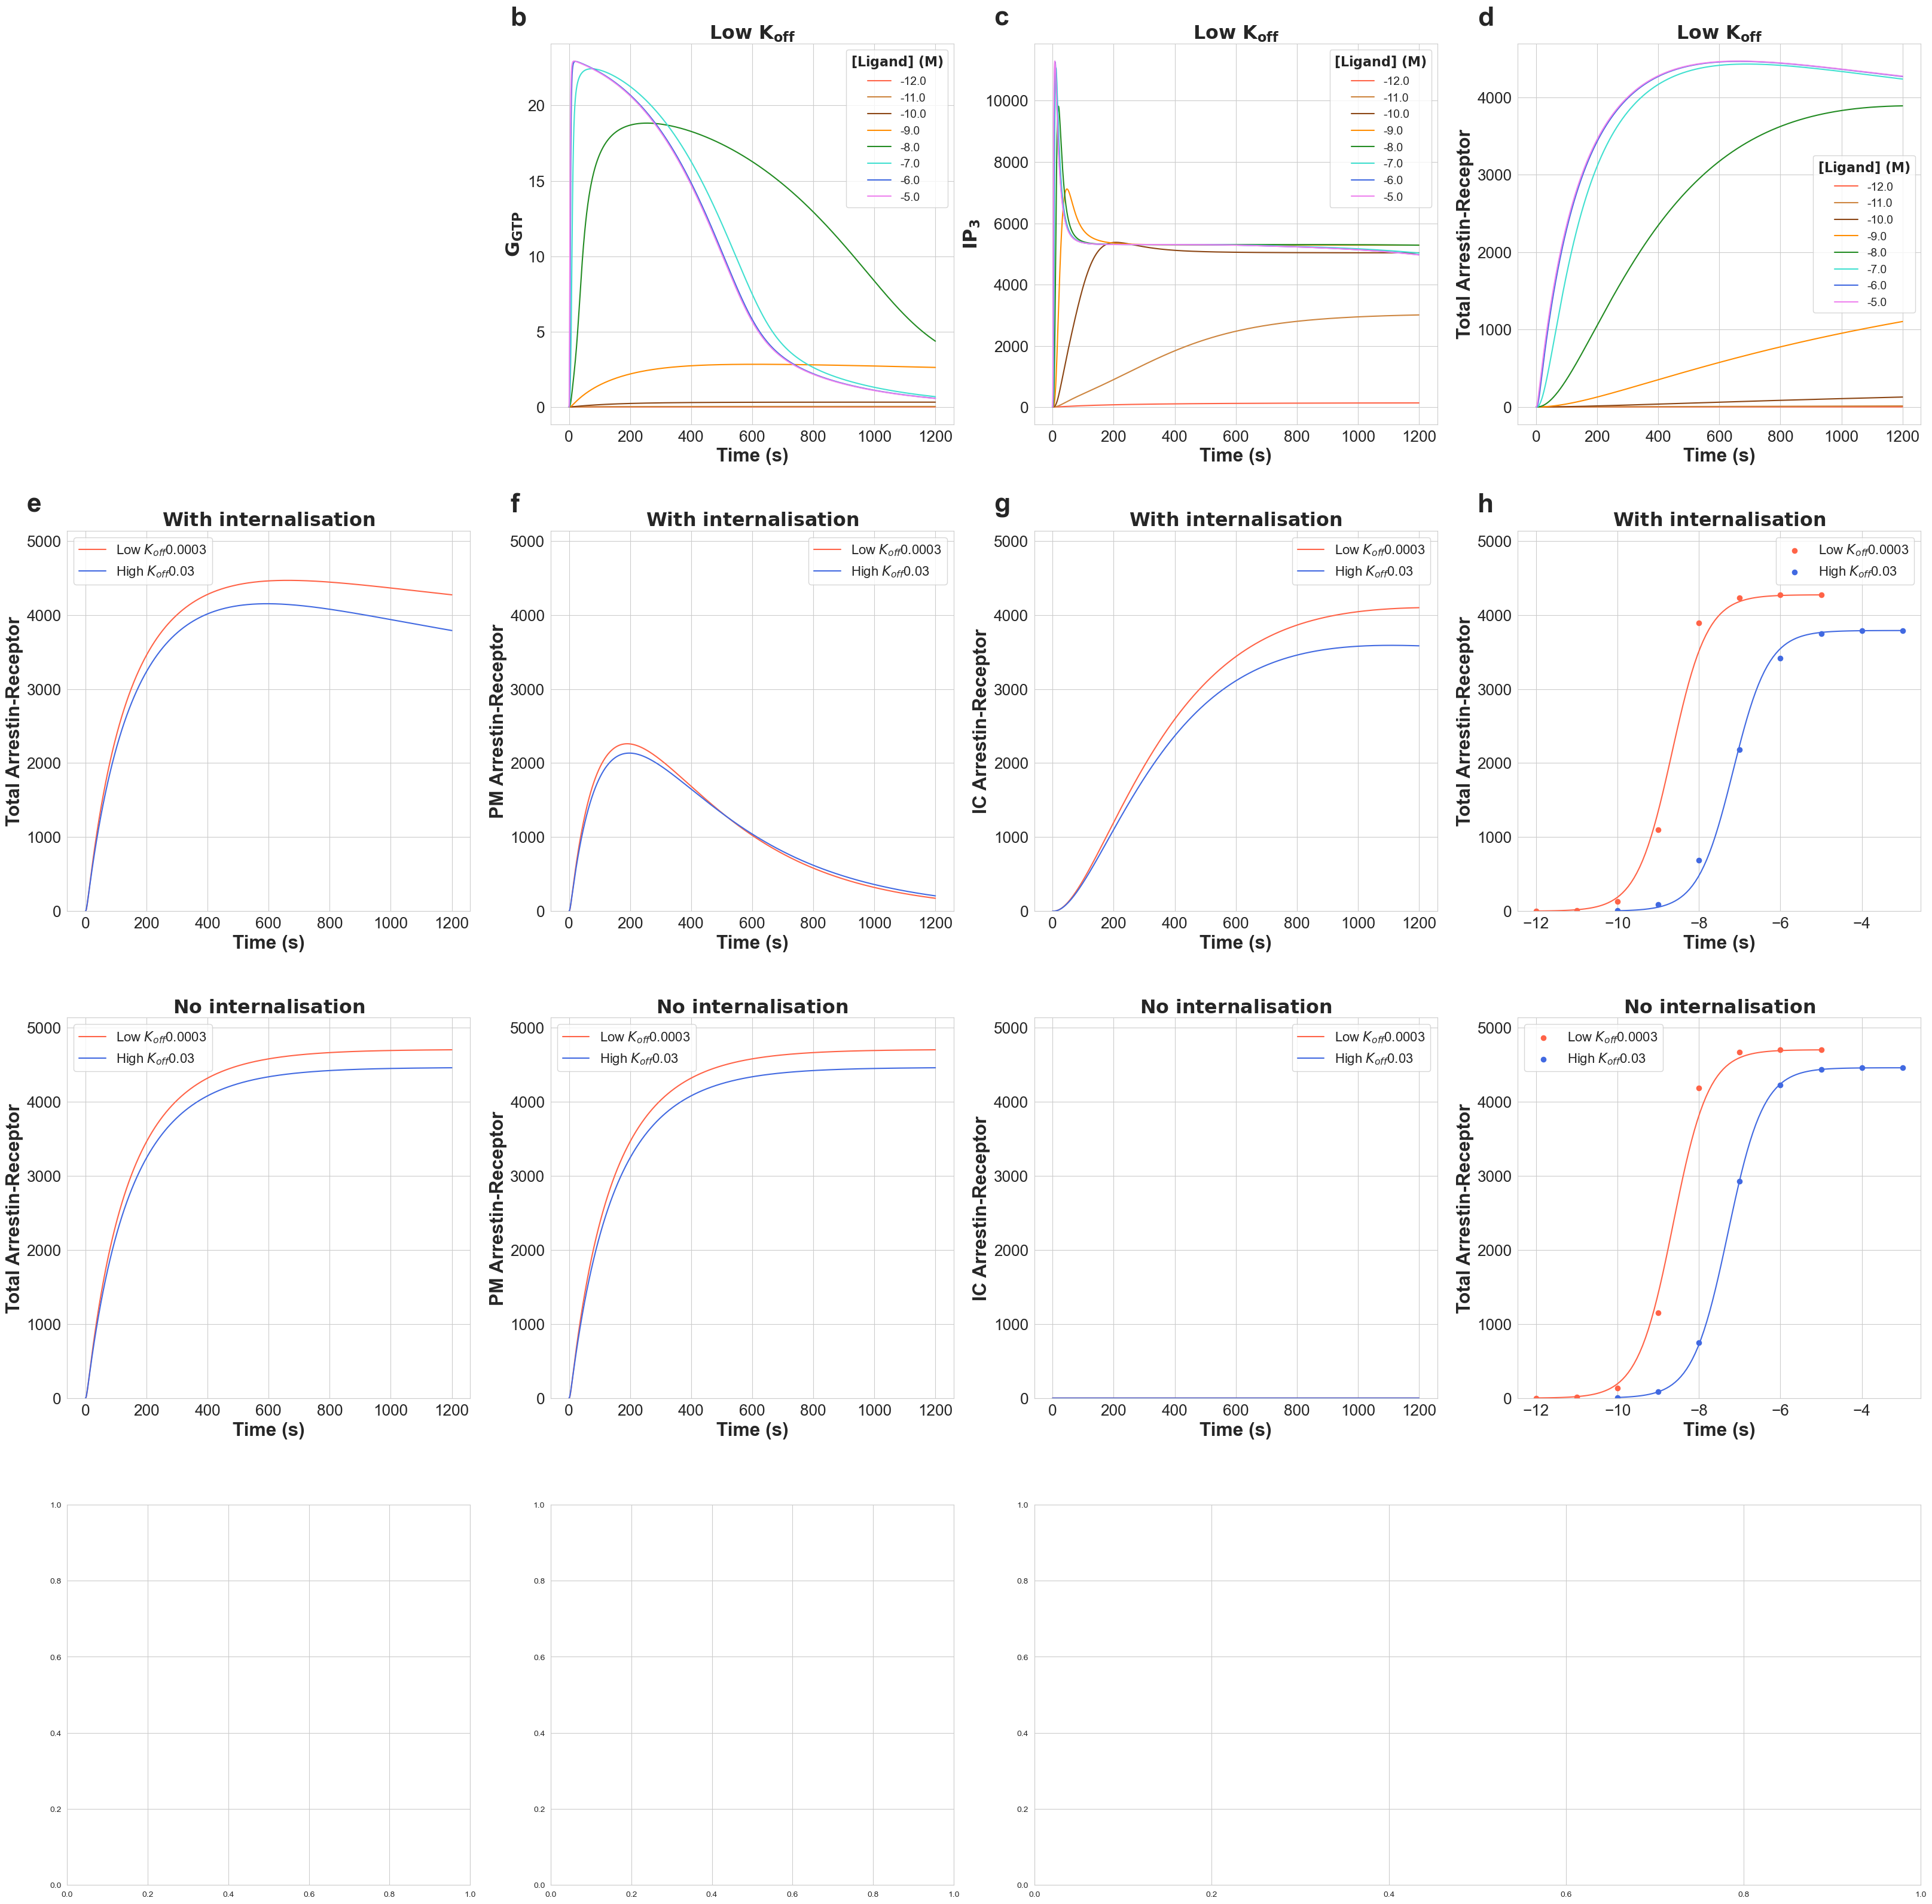

In [8]:
subplots_names=[['H_up'],['H_low']]
subplot_labels=['H']
molecules_to_plot=['Total Arrestin-Receptor']

### Load the previosly ceated figur and axes object to plot to
with open('../data/temp_data_for_plotting/temporary_plot_B_G_fig_object.pkl','rb') as file:
    fig=pickle.load(file)
    plt.close()
with open('../data/temp_data_for_plotting/temporary_plot_B_G_axes_object.pkl','rb') as file:
    ax=pickle.load(file)

time_to_response=1200

kon=0.3
koff_list=[0.0003,0.03]
internalisation_status=['With_internalisation','No_internalisation']
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','royalblue']#'peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40

#fig,ax=plt.subplot_mosaic(subplot_layout,figsize=(fig_width,fig_height))

## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=100
subplot_legend_title_fontsize_nominator=100
#legend_title='$\mathbf{K_{off}}$'
legend_title=None
legend_handles=['Low $K_{off}$','High $K_{off}$']
plot_dot_size=35



for molecule,colnum,subplot_label in zip(molecules_to_plot,range(np.asarray(subplots_names).shape[1]),subplot_labels):
    for intern_status,rownum in zip(internalisation_status,range(np.asarray(subplots_names).shape[0])):
        subplot_name=subplots_names[rownum][colnum]
        ax[subplot_name]=draw_DR_points_plus_fit_DR_curve(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                                        color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                        subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                        subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                        legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                                                        subplot_label,subplot_label_fontsize_nominator,plot_dot_size)

## Save fig and axes object for later to add more subplots to it
with open('../data/temp_data_for_plotting/temporary_plot_B_H_fig_object.pkl','wb') as file:
    pickle.dump(fig,file)
with open('../data/temp_data_for_plotting/temporary_plot_B_H_axes_object.pkl','wb') as file:
    pickle.dump(ax,file)


### Add Emax-logEC50 plots (__I - J__)

In [9]:
def draw_emax_ec50_plot(molecule,molecules_dict,kon_list,koff_list,intern_status,process_name,ligand_ccs,\
                        color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                        subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                        subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                        legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                        subplot_label,subplot_label_fontsize_nominator,marker_size_nominator,marker_list):
    
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',intern_status,process_name,'')

    ## Define which subplot we want to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    plot_area=fig_width*fig_height

    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
    for kon,color in zip(kon_list,colors):
        Emax_list=[]
        logec50_list=[]
        for koff in koff_list:
            ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
            ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

            ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
            DR_points=[]

            for ligand in ligands:
                fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
                col_nums=[int(x+1) for x in molecules_dict[molecule]]
                col_nums.append(0)
                mol_ccs_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
                response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
                DR_points.append(response_at_time)
            
            ## Function to fit DR curve on the DR-points extracted from the simulated data and return logEC50 for plotting the fitted DR curve
            def func(ligands, logec50):
                return max(DR_points) / (1 + 10 ** (logec50 - np.log10(ligands)))
            logec50, pcov = curve_fit(func, 10**ligands, DR_points,bounds=(-19,-1))

            ## Add EC50 and Emax to list
            logec50_list.append(logec50)
            Emax_list.append(DR_points[-1])

        ## Plot the Emax values on the y-axis and logec50 values on the x-axis
        for logec50,Emax,marker,koff in zip(logec50_list,Emax_list,marker_list,koff_list):
            axis.scatter(logec50, Emax,label=str(kon)+ ' - '+str(koff), color=color,s=plot_area/marker_size_nominator,marker=marker)
        
        
    #plot=axis.plot(mol_ccs_df.index.tolist(),np.sum(mol_ccs_df.loc[:,:],1),label=label,color=color)
    
    ## Customize legend, plot title, axis labels 

    axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title_text=intern_status.replace('_','\ ')
    title="$\mathbf{E_{max}}$" +' - ' "$\mathbf{logEC_{50}}$"
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('$\mathbf{logEC_{50}}$',fontweight="bold",fontsize=axis_label_fontsize)

    ## If molecule is G_GTP, then do not change anything on that part of the string, as it is already TeX formulated
    if 'GTP' in molecule:
        y_axis_label=molecule + "\n"+ "$\mathbf{(E_{max})}$"
    
    ## TeX formulate Total Arrestin-Receptor string
    else:
        label_text=molecule.replace(' ','\ ')
        y_axis_label=r"$\mathbf{{title}}$".replace('title',label_text) + "\n"+ "$\mathbf{(E_{max})}$"

    axis.set_ylabel(y_axis_label,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    #axis.set_ylim(0,ylim)

    axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)

    return(axis)

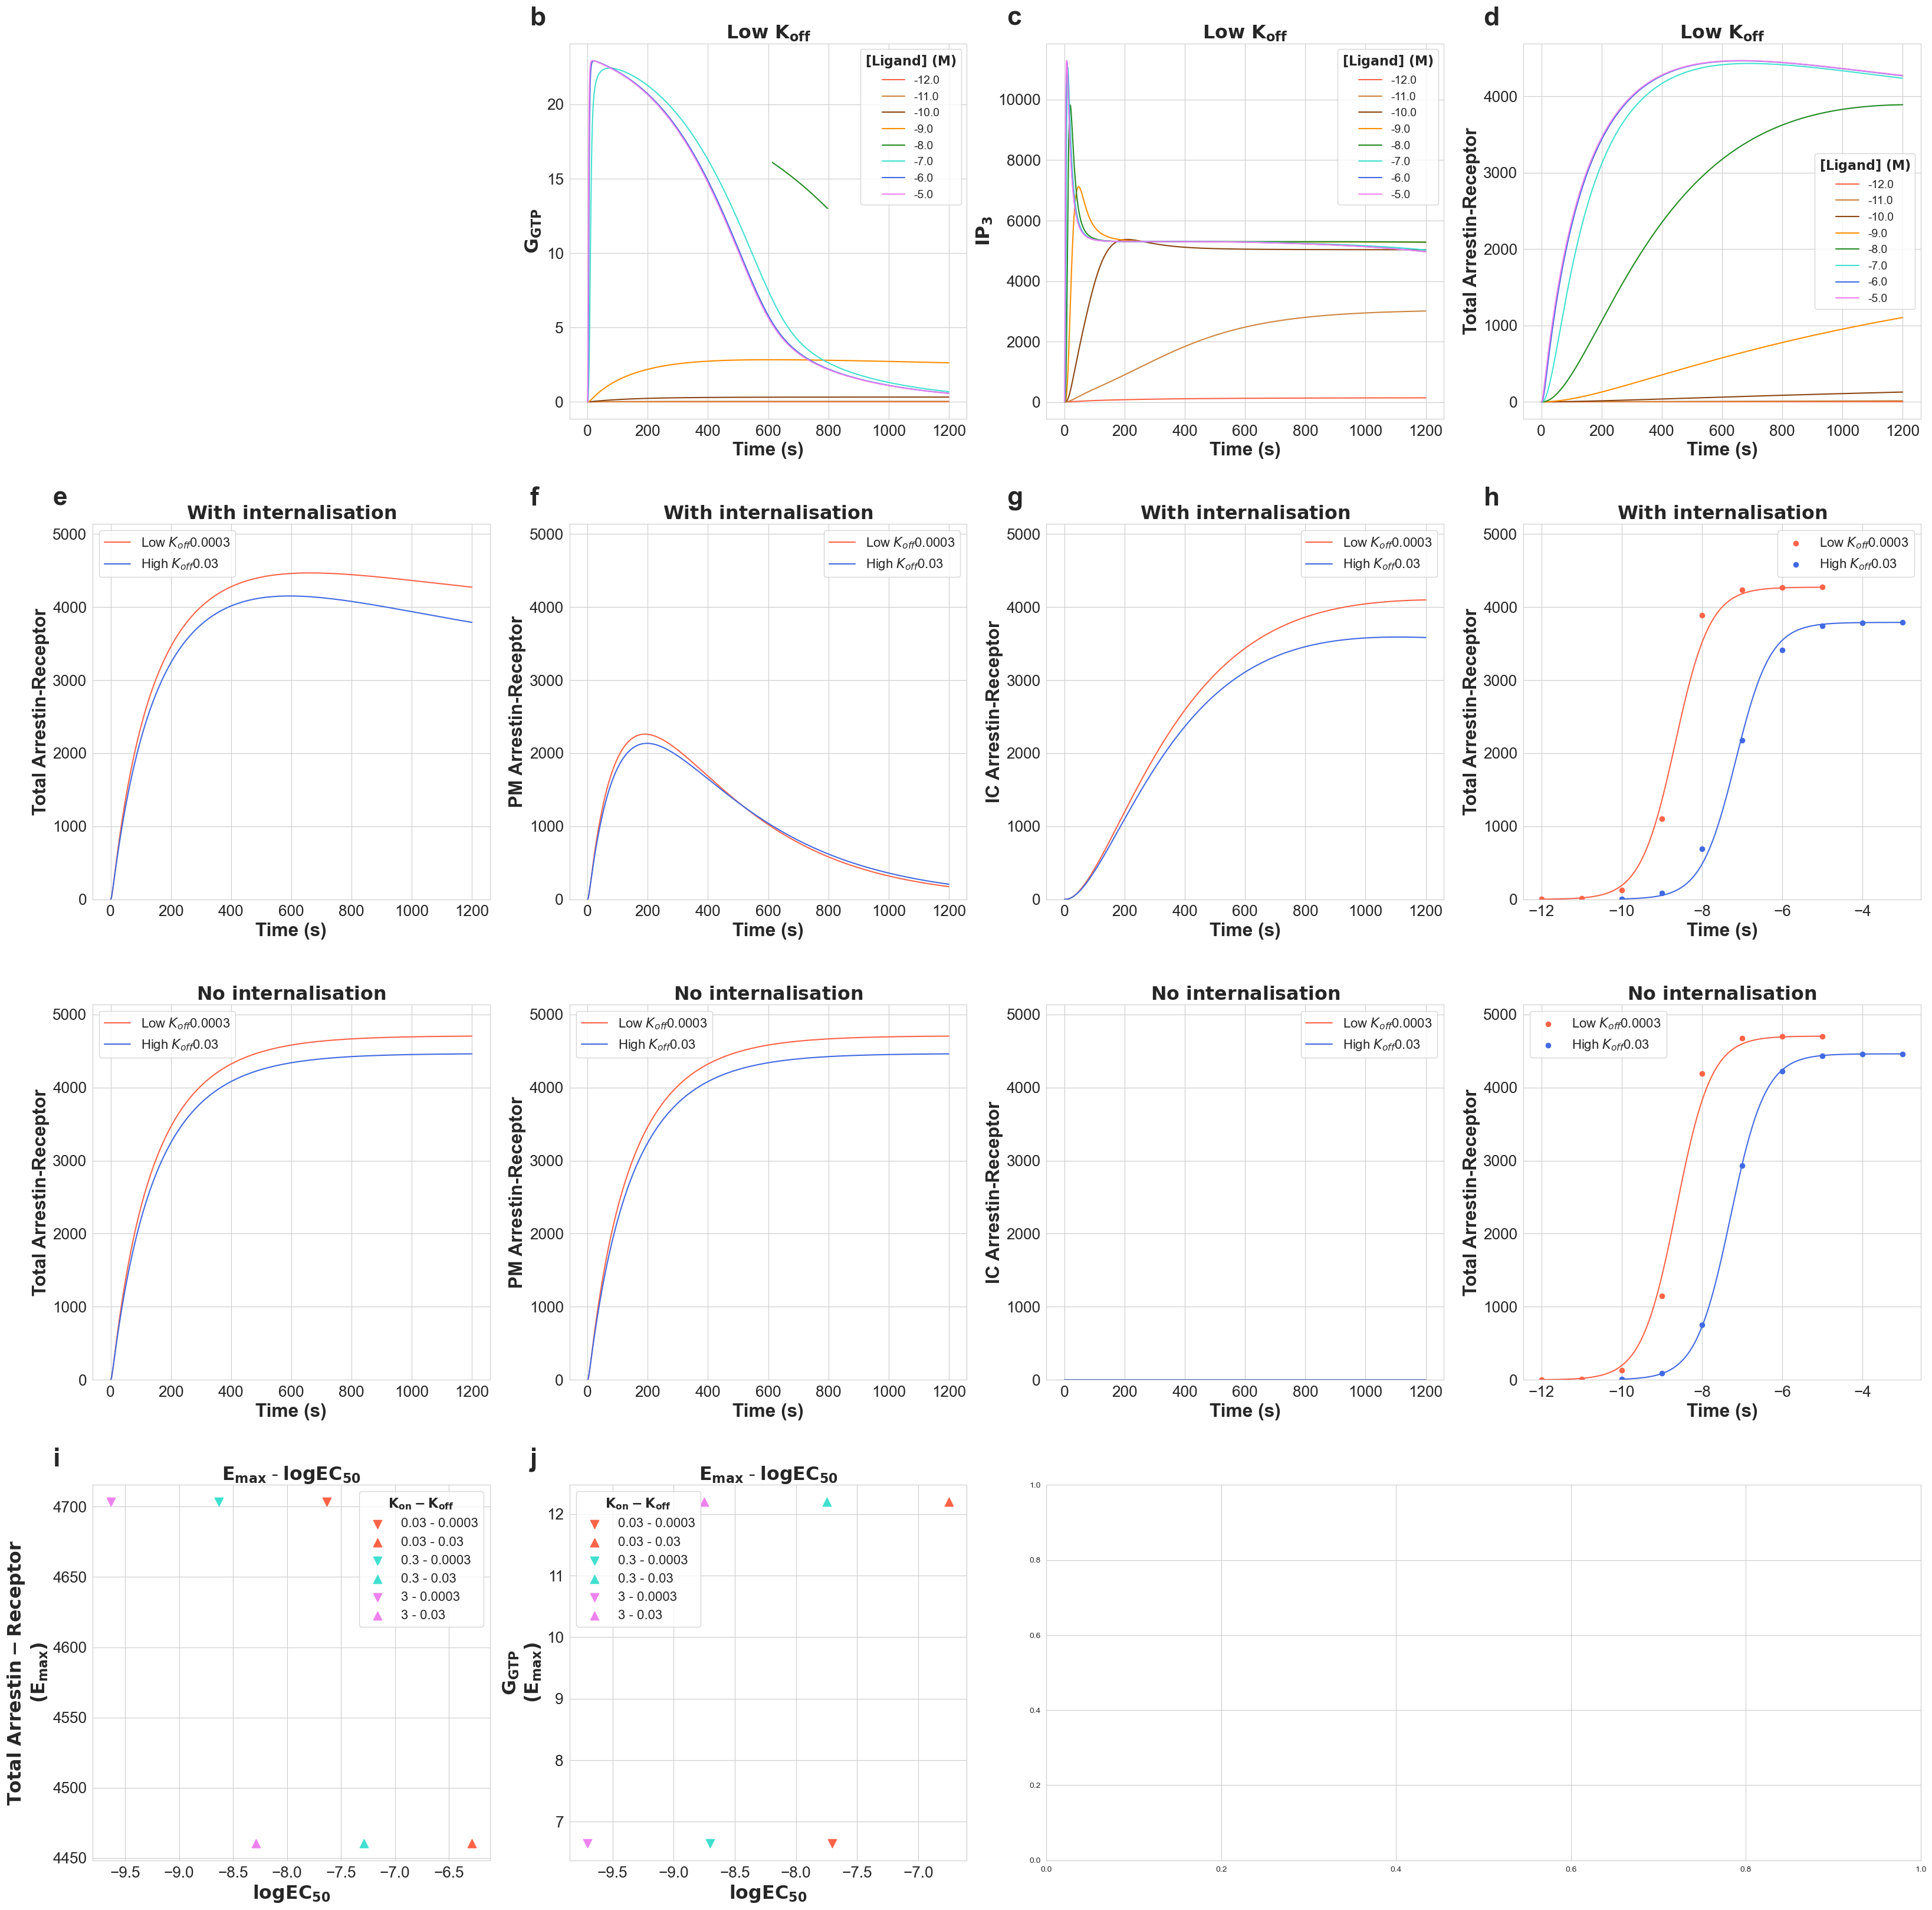

In [10]:
subplots_names=['I','J']
subplot_labels=['I','J']
molecules_to_plot=['Total Arrestin-Receptor','$\mathbf{G_{GTP}}$']

### Load the previosly ceated figur and axes object to plot to
with open('../data/temp_data_for_plotting/temporary_plot_B_H_fig_object.pkl','rb') as file:
    fig=pickle.load(file)
    plt.close()
with open('../data/temp_data_for_plotting/temporary_plot_B_H_axes_object.pkl','rb') as file:
    ax=pickle.load(file)

time_to_response=1200

kon_list=[0.03,0.3,3]
koff_list=[0.0003,0.03]
internalisation_status=['With_internalisation','No_internalisation']
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','turquoise','violet']#'peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40


## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=100
subplot_legend_title_fontsize_nominator=100
legend_title='$\mathbf{K_{on}-K_{off}}$'
#legend_handles=['Low $K_{off}$','High $K_{off}$']
marker_size_nominator=15

marker_list=["v","^"]



for molecule,subplot_name,subplot_label in zip(molecules_to_plot,subplots_names,subplot_labels):
        ax[subplot_name]=draw_emax_ec50_plot(molecule,molecules_dict,kon_list,koff_list,intern_status,process_name,ligand_ccs,\
                                            color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                            subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                            subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                            legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                                            subplot_label,subplot_label_fontsize_nominator,marker_size_nominator,marker_list)

## Save fig and axes object for later to add more subplots to it
with open('../data/temp_data_for_plotting/temporary_plot_B_J_fig_object.pkl','wb') as file:
    pickle.dump(fig,file)
with open('../data/temp_data_for_plotting/temporary_plot_B_J_axes_object.pkl','wb') as file:
    pickle.dump(ax,file)


### Add Kinetic bias heatmap  (__K__)

In [11]:
def draw_kinetic_bias_heatmap(pathway1,pathway2,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                        color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                        subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                        subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                        legend_title,hm_cbar_legend_title_fontsize_nominator,legend_handles,timepoint_list,ylim,\
                        subplot_label,subplot_label_fontsize_nominator,hm_annot_fontsize_nominator,hm_cbar_axis_fontsize_nominator):
    
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',intern_status,process_name,'')

    ## Define which subplot we want to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    plot_area=fig_width*fig_height


    ## Create dictionary to collect results for each timepoint
    bias_factor_results_dict={}
    for time_to_response in timepoint_list:
        bias_factor_results_dict[time_to_response]={}
        for koff in koff_list:
            bias_factor_results_dict[time_to_response][koff]={}
            ## Collect Emax and logEC50 values for both reference and query ligand
            emax_dict={}
            ec50_dict={}
            for ligand_type,kon_ligand,koff_ligand in zip(['reference','ligand'],[0.3,kon],[0.0003,koff]):
                emax_dict[ligand_type]={}
                ec50_dict[ligand_type]={}

                ## Calculate Emax and logEC50 for both molecules per ligand type. 
                #  The bias factor is a comparison of the concentrations of the 2 molecules, 
                #  which indicates how biased the ligand is towards one of the compared pathways
                for pathway in [pathway1,pathway2]:                                                   
                    ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
                    DR_points=[]

                    ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L 
                    # (by subtracting 6 from hte logarithmic values of ligand ccs)
                    ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff_ligand,kon_ligand)) - 6

                    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
                    #  Extractn the molecule concantration at given timepoint -> collect it to DR_points
                    for ligand in ligands:
                        fname=dirname+ '_'.join([process_name,'koff',str(koff_ligand),'kon',str(kon_ligand),'ligand_cc',str(ligand)]) + '.csv'
                        col_nums=[int(x+1) for x in molecules_dict[pathway]]
                        col_nums.append(0)
                        mol_ccs_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
                        response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
                        DR_points.append(response_at_time)     

                    ## Function to fit DR curve on the DR-points extracted from the simulated data and return logEC50 for calculating bias factor
                    def func(ligands, logec50):
                        return max(DR_points) / (1 + 10 ** (logec50 - np.log10(ligands)))
                    logec50, pcov = curve_fit(func, 10**ligands, DR_points,bounds=(-19,-1))

                    ## Add EC50 and Emax values to respective dictionaries
                    emax_dict[ligand_type][pathway]=DR_points[-1]
                    ec50_dict[ligand_type][pathway]=10**logec50

            ## Assign elements to variables in order make to calculation of Bias factor easy to interpret
            emax_p1_ref=emax_dict['reference'][pathway1]
            emax_p2_ref=emax_dict['reference'][pathway2]
            ec50_p1_ref=ec50_dict['reference'][pathway1]
            ec50_p2_ref=ec50_dict['reference'][pathway2]
            emax_p1_lig=emax_dict['ligand'][pathway1]
            emax_p2_lig=emax_dict['ligand'][pathway2]
            ec50_p1_lig=ec50_dict['ligand'][pathway1]
            ec50_p2_lig=ec50_dict['ligand'][pathway2]

            # Calculate Bias factor
            bias_factor=math.log10(((emax_p1_lig*ec50_p2_lig)/(ec50_p1_lig*emax_p2_lig)) * ((emax_p2_ref*ec50_p1_ref)/(ec50_p2_ref*emax_p1_ref)))
            
            ## Round bias factor to 0 if sufficiently enough to 0
            if abs(bias_factor)<0.000001:
                bias_factor=0
            bias_factor_results_dict[time_to_response][koff]=bias_factor

    ## Convert dictionery of result to DataFrame and plot a heatmap
    bias_factor_df=pd.DataFrame.from_dict(bias_factor_results_dict)
    bias_factor_df=bias_factor_df.set_axis(["$\mathbf{Low\ K_{off}}$","$\mathbf{High\ K_{off}}$"])
    
    # PLot heatmap and customize legend
    hm=sns.heatmap(bias_factor_df,annot=True,cmap="YlGnBu", ax=axis,fmt='.3f',vmin=-1,vmax=1,
                   cbar_kws={'ticks':[-1,-0.5,0,0.5,1.0],
                             'label':legend_title,
                             'fraction':0.08},
                   annot_kws={'fontsize':plot_area/hm_annot_fontsize_nominator})   
    cbar_ax=hm.figure.axes[-1]
    cbar_ax.tick_params(labelsize=plot_area/hm_cbar_axis_fontsize_nominator)
    cbar_ax.yaxis.label.set_size(plot_area/hm_cbar_legend_title_fontsize_nominator)    
   
    ## Customize legend, plot title, axis labels        

    #axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
    #            fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    ## If pathwy1 is G_GTP, then do not change anything on that part of the string, as it is already TeX formulated and
    #  TeX formulate Total Arrestin-Receptor string
    if 'GTP' in pathway1:
        title_text2=pathway1
        title_text1=pathway1.replace(' ','\ ')
        title_text1="$\mathbf{{title}}$".replace('title',title_text1)
    elif 'GTP' in pathway2:
        title_text2=pathway1.replace(' ','\ ')
        title_text2="$\mathbf{{title}}$".replace('title',title_text2)
        title_text1=pathway2

    title="$\mathbf{Bias\ factor}$" +" (" +title_text1+ ' vs. ' +title_text2 +')'
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize,fontweight='bold')

    axis.set_xlabel('Time (s)',fontweight="bold",fontsize=axis_label_fontsize)

    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    #axis.set_ylim(0,ylim)

    axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)

    return(hm)

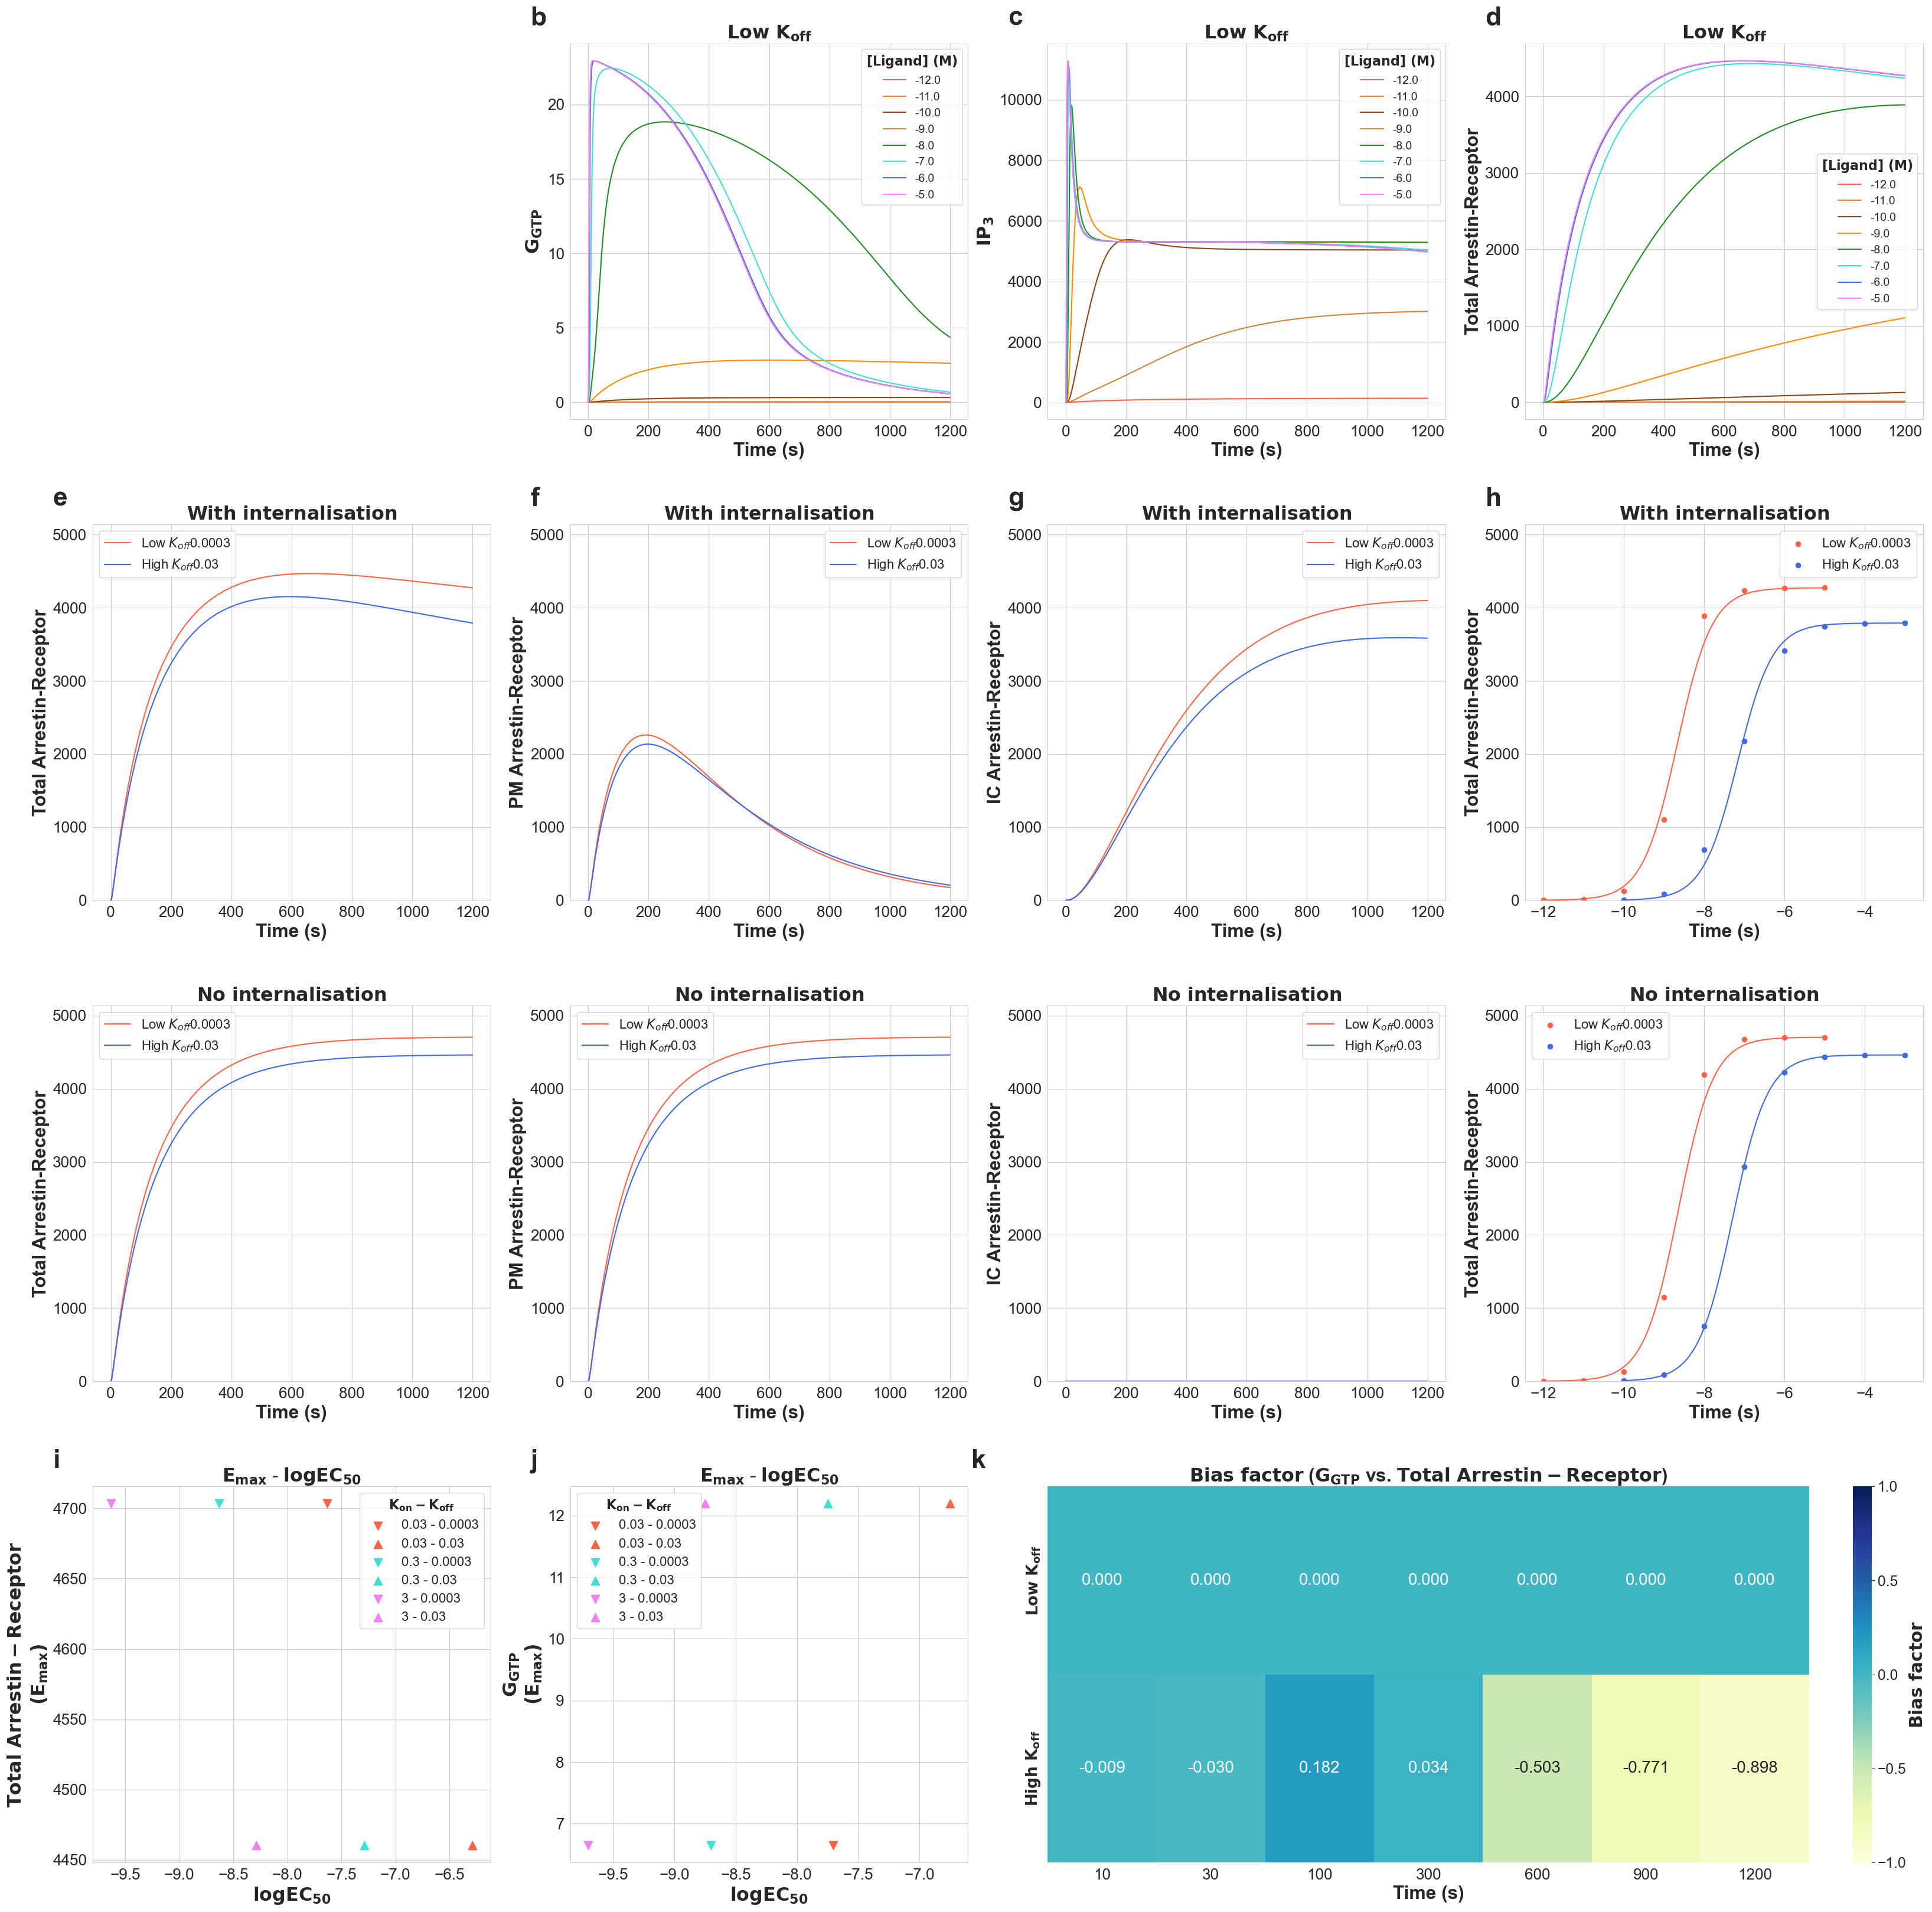

In [12]:
subplots_names=['K']
subplot_labels=['K']
molecules=['Total Arrestin-Receptor','$\mathbf{G_{GTP}}$']

pathway1='Total Arrestin-Receptor'
pathway2='$\mathbf{G_{GTP}}$'

### Load the previosly ceated figur and axes object to plot to
with open('../data/temp_data_for_plotting/temporary_plot_B_J_fig_object.pkl','rb') as file:
    fig=pickle.load(file)
    plt.close()
with open('../data/temp_data_for_plotting/temporary_plot_B_J_axes_object.pkl','rb') as file:
    ax=pickle.load(file)

time_to_response=1200

timepoint_list=[10,30,100,300,600,900,1200]
kon_list=[0.3]
kon=0.3
koff_list=[0.0003,0.03]
internalisation_status=['With_internalisation','No_internalisation']
intern_status='With_internalisation'
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','turquoise','violet']#'peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40


## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=100

legend_title='$\mathbf{Bias\ factor}$'
#legend_handles=['Low $K_{off}$','High $K_{off}$']
hm_annot_fontsize_nominator=80

hm_cbar_axis_fontsize_nominator=90
hm_cbar_legend_title_fontsize_nominator=75


for subplot_name,subplot_label in zip(subplots_names,subplot_labels):
        ax[subplot_name]=draw_kinetic_bias_heatmap(pathway1,pathway2,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                                color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                legend_title,hm_cbar_legend_title_fontsize_nominator,legend_handles,timepoint_list,ylim,\
                                                subplot_label,subplot_label_fontsize_nominator,hm_annot_fontsize_nominator,hm_cbar_axis_fontsize_nominator)

plt.savefig('../data/temp_data_for_plotting/temporary_plot_B_K.png',dpi=300,bbox_inches='tight')
## Save fig and axes object for later to add more subplots to it
with open('../data/temp_data_for_plotting/temporary_plot_B_K_fig_object.pkl','wb') as file:
    pickle.dump(fig,file)
with open('../data/temp_data_for_plotting/temporary_plot_B_K_axes_object.pkl','wb') as file:
    pickle.dump(ax,file)

### Add boxplots with perturbations of different cellular processes heatmap  (__L__)

In [73]:
def create_perturbations_df(molecules,molecules_dict,kon,koff_list,intern_status,perturbed_processes,ligand_ccs,time_to_response,\
                            factor_list):

    for koff in koff_list:
        ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
        ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

        ## Create dataframe to collect all of the results into
        perturbations_df_colnames=molecules + ['Factor','Perturbed process']
        perturbations_df=pd.DataFrame(columns=perturbations_df_colnames)
        
        for process_name in perturbed_processes:
            ## Create directory path to load the data from
            dirname=os.path.join('../data/',intern_status,process_name,'')
            
            ## Create temporary dictionary collect the results of one perturbed process, which will get converted to DataFrame concatenated to perturbations_df
            process_results_dict={}
            
            for factor in factor_list:
                process_results_dict[factor]={}
                for molecule in molecules:
                                                    
                    ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
                    DR_points=[]

                    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
                    for ligand in ligands:
                        fname=dirname+ '_'.join([process_name,str(factor),'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
                        col_nums=[int(x+1) for x in molecules_dict[molecule]]
                        col_nums.append(0)
                        mol_ccs_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
                        response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
                        DR_points.append(response_at_time)
                    
                    ## Append Emax value at given perturbation factor for given molecule, for given process and Koff/Kon
                    process_results_dict[factor][molecule]=DR_points[-1]
            
            ## Convert the results of perturbation of one process into a DataFrame
            process_df=pd.DataFrame.from_dict(process_results_dict)
            process_df=process_df.T
            process_df['Perturbed process']=process_name
            process_df=process_df.rename_axis('Factor').reset_index()


            ## Concatenate the results from one process to the main result dataframe
            perturbations_df=pd.concat([perturbations_df,process_df],join="outer",ignore_index=True)

    return perturbations_df



def create_perturbations_boxplot(perturbations_df,molecules,molecules_dict,kon,koff_list,intern_status,perturbed_processes,ligand_ccs,\
                                color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                subplot_y_axis_tick_label_fontsize_nominator,subplot_x_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                                subplot_label,subplot_label_fontsize_nominator,marker_size_nominator,factor_list,figure_title,\
                                figure_title_fontsize_nominator):
    

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]
    plot_area=fig_width*fig_height

    ## Define which subplot we want to plot into from the original subplot_mosaic object
    #axis=ax[subplot_name]

    plot_df=perturbations_df.melt(id_vars=["Factor",'Perturbed process'],var_name="Molecule",value_name="Values")
    plot_df['Factor']=plot_df['Factor'].astype(str)
    plot_df['Perturbed process']=plot_df['Perturbed process'].str.replace('_',' ')


    palette = sns.color_palette("ch:2.5,-.2,dark=.3",n_colors=len(factor_list))
    
    g=sns.FacetGrid(data=plot_df, col='Molecule',height=4, aspect=1.2,sharey=False)
    g.map_dataframe(sns.swarmplot,x="Perturbed process", y="Values",hue='Factor',palette=palette)
    g.map_dataframe(sns.boxplot,x="Perturbed process", y="Values",boxprops={'facecolor':'None'})
    g.add_legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)

    g.fig.suptitle(figure_title,fontsize=plot_area/figure_title_fontsize_nominator)
    
    ## Customize legend, plot title, axis labels 
    for g_ax, molecule in zip(g.axes.flat,molecules):
        
        title_fontsize=plot_area/subplot_title_fontsize_nominator
        title_text=molecule.replace(' ','\ ')
        title_text="$\mathbf{{title}}$".replace('title',title_text)
        g_ax.set_title(None,fontsize=title_fontsize)

        ## If molecule is G_GTP, then do not change anything on that part of the string, as it is already TeX formulated
        if 'GTP' in molecule:
            y_axis_label=molecule + "\n"+ "$\mathbf{(E_{max})}$"
        
        ## TeX formulate Total Arrestin-Receptor string
        else:
            label_text=molecule.replace(' ','\ ')
            y_axis_label=r"$\mathbf{{title}}$".replace('title',label_text) + " "+ "$\mathbf{(E_{max})}$"

        axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
        y_axis_tick_labelsize=plot_area/subplot_y_axis_tick_label_fontsize_nominator
        x_axis_tick_labelsize=plot_area/subplot_x_axis_tick_label_fontsize_nominator
        g_ax.set_ylabel(y_axis_label,fontweight="bold",fontsize=axis_label_fontsize)
        g_ax.tick_params(axis='y', labelsize=y_axis_tick_labelsize)
        g_ax.set_xlabel(None,fontweight="bold",fontsize=axis_label_fontsize)
        g_ax.set_xticklabels(g_ax.get_xticklabels(), rotation=90, weight='bold', size=x_axis_tick_labelsize)
        #g_ax.tick_params(axis='x', weight="bold",labelsize=x_axis_tick_labelsize,rotation=90)


    '''
    axis.set_xlabel('$\mathbf{logEC_{50}}$',fontweight="bold",fontsize=axis_label_fontsize)
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title_text=intern_status.replace('_','\ ')
    title="$\mathbf{E_{max}}$" +' - ' "$\mathbf{logEC_{50}}$"
    
    

    

    ## If molecule is G_GTP, then do not change anything on that part of the string, as it is already TeX formulated
    if 'GTP' in molecule:
        y_axis_label=molecule + "\n"+ "$\mathbf{(E_{max})}$"
    
    ## TeX formulate Total Arrestin-Receptor string
    else:
        label_text=molecule.replace(' ','\ ')
        y_axis_label=r"$\mathbf{{title}}$".replace('title',label_text) + "\n"+ "$\mathbf{(E_{max})}$"

    axis.set_ylabel(y_axis_label,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    #axis.set_ylim(0,ylim)

    axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)
    '''
    return(g)
    

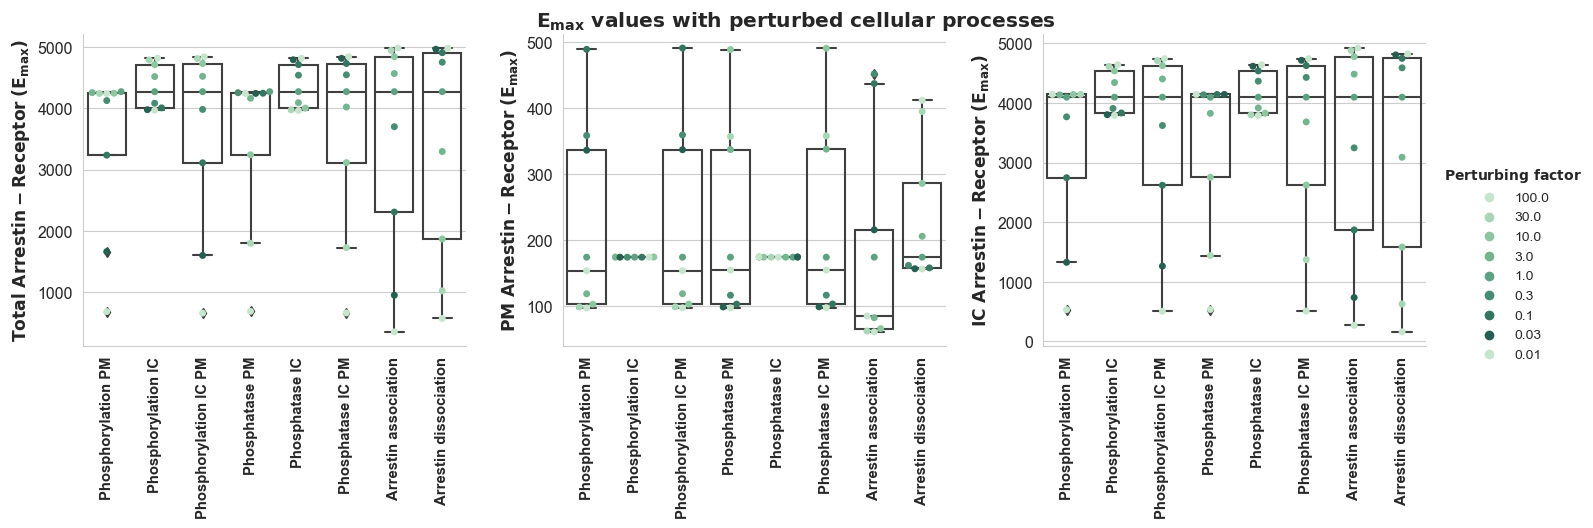

In [75]:
subplots_names=['L']
subplot_labels=['L']
molecules=['Total Arrestin-Receptor','PM Arrestin-Receptor','IC Arrestin-Receptor']

'''
### Load the previosly ceated figur and axes object to plot to
with open('../data/temp_data_for_plotting/temporary_plot_B_K_fig_object.pkl','rb') as file:
    fig=pickle.load(file)
    plt.close()
with open('../data/temp_data_for_plotting/temporary_plot_B_K_axes_object.pkl','rb') as file:
    ax=pickle.load(file)
'''
time_to_response=1200
factor_list=[100,30,10,3,0.3,0.1,0.03,0.01]

kon=0.3
koff_list=[0.0003]
intern_status='With_internalisation'
perturbed_processes=['Phosphorylation_PM','Phosphorylation_IC','Phosphorylation_IC_PM',
                    'Phosphatase_PM','Phosphatase_IC','Phosphatase_IC_PM',
                    'Arrestin_association','Arrestin_dissociation']

process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet','black']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40


## FOntsize=fig_width*fig_height/title_fontsize_ratio
figure_title='$\mathbf{E_{max}\ values\ with\ perturbed\ cellular\ processes}$'
figure_title_fontsize_nominator=110

subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=110

subplot_axis_label_fontsize_nominator=130

subplot_y_axis_tick_label_fontsize_nominator=140
subplot_x_axis_tick_label_fontsize_nominator=150

subplot_legend_label_fontsize_nominator=160
subplot_legend_title_fontsize_nominator=120
legend_title='$\mathbf{Perturbing\ factor}$'
#legend_handles=['Low $K_{off}$','High $K_{off}$']

hm_annot_fontsize_nominator=80

hm_cbar_axis_fontsize_nominator=90
hm_cbar_legend_title_fontsize_nominator=75


## Create dataframe and savce it first, as it takes 2-3 minutes to compute
#perturbations_df=create_perturbations_df(molecules,molecules_dict,kon,koff_list,intern_status,perturbed_processes,ligand_ccs,time_to_response,factor_list)
#perturbations_df.to_csv('../data/temp_data_for_plotting/plot_L_perturbations_df.csv')

## Read previously computed dataframe for plotting
perturbations_df=pd.read_csv('../data/temp_data_for_plotting/plot_L_perturbations_df.csv',index_col=0)




for subplot_name,subplot_label in zip(subplots_names,subplot_labels):
    g=create_perturbations_boxplot(perturbations_df,molecules,molecules_dict,kon,koff_list,intern_status,perturbed_processes,ligand_ccs,\
                                                color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                subplot_y_axis_tick_label_fontsize_nominator,subplot_x_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                                                subplot_label,subplot_label_fontsize_nominator,marker_size_nominator,factor_list,figure_title,\
                                                figure_title_fontsize_nominator)

    plt.show()
g.savefig('../data/temp_data_for_plotting/temporary_plot_L.png',dpi=300)



In [77]:

subplots_B_K=Image.open('../data/temp_data_for_plotting/temporary_plot_B_K.png')
subplots_L=Image.open('../data/temp_data_for_plotting/temporary_plot_L.png')

subplots=[subplots_B_K,subplots_L]
resized_subplots=[subplots_B_K]
for im in subplots[1:]:
    scale_ratio=subplots_B_K.size[0]/im.size[0]
    resized_subplot=im.resize((subplots_B_K.size[0],int(im.size[1]*scale_ratio)))
    resized_subplots.append(resized_subplot)

widths, heights = zip(*(i.size for i in resized_subplots))

total_width = max(widths)
max_height = sum(heights)

new_im = Image.new('RGB', (total_width, max_height+1000))


y_offsets=[0,]
y_offset = 0
for im in resized_subplots:
    print(y_offset)
    new_im.paste(im, (0,y_offset))
    y_offset += im.size[1]
  
new_im.show()
#new_im.save('../data/temp_data_for_plotting/test.png')


'''
a=perturbations_df.melt(id_vars=["Factor",'Perturbed process'],var_name="Molecule",value_name="Values")
a['Factor']=a['Factor'].astype(str)
palette = sns.color_palette("ch:2.5,-.2,dark=.3",n_colors=len(factor_list))
#fig,ax=plt.subplots(1,1,figsize=(30,15))


## Save fig and axes object for later to add more subplots to it
with open('../data/temp_data_for_plotting/temporary_plot_B_L_fig_object.pkl','wb') as file:
    pickle.dump(fig,file)
with open('../data/temp_data_for_plotting/temporary_plot_B_L_axes_object.pkl','wb') as file:
    pickle.dump(ax,file)
'''

/Users/daniel.garger/anaconda3/envs/pytorch/lib/python3.10/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (95079976 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


0
9706


'\na=perturbations_df.melt(id_vars=["Factor",\'Perturbed process\'],var_name="Molecule",value_name="Values")\na[\'Factor\']=a[\'Factor\'].astype(str)\npalette = sns.color_palette("ch:2.5,-.2,dark=.3",n_colors=len(factor_list))\n#fig,ax=plt.subplots(1,1,figsize=(30,15))\n\n\n## Save fig and axes object for later to add more subplots to it\nwith open(\'../data/temp_data_for_plotting/temporary_plot_B_L_fig_object.pkl\',\'wb\') as file:\n    pickle.dump(fig,file)\nwith open(\'../data/temp_data_for_plotting/temporary_plot_B_L_axes_object.pkl\',\'wb\') as file:\n    pickle.dump(ax,file)\n'